In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.decomposition import PCA

Получаем путь к файлу

In [17]:
csv_path = os.path.join("data", "Car_Price_Prediction.csv")

1. Загрузка датасета

In [18]:
df = pd.read_csv(csv_path)

2.Первичый анализ данных:
    Размер и структура

In [19]:
print("Размер датасета:", df.shape)
print("\nТипы данных:\n", df.dtypes)

Размер датасета: (1000, 8)

Типы данных:
 Make             object
Model            object
Year              int64
Engine Size     float64
Mileage           int64
Fuel Type        object
Transmission     object
Price           float64
dtype: object


Первые и последние строки

In [20]:
print("\nПервые 5 строк:\n", df.head())
print("\nПоследние 5 строк:\n", df.tail())


Первые 5 строк:
     Make    Model  Year  Engine Size  Mileage Fuel Type Transmission  \
0  Honda  Model B  2015          3.9    74176    Petrol       Manual   
1   Ford  Model C  2014          1.7    94799  Electric    Automatic   
2    BMW  Model B  2006          4.1    98385  Electric       Manual   
3  Honda  Model B  2015          2.6    88919  Electric    Automatic   
4  Honda  Model C  2004          3.4   138482    Petrol    Automatic   

          Price  
0  30246.207931  
1  22785.747684  
2  25760.290347  
3  25638.003491  
4  21021.386657  

Последние 5 строк:
        Make    Model  Year  Engine Size  Mileage Fuel Type Transmission  \
995  Toyota  Model D  2002          1.9     5445    Petrol       Manual   
996   Honda  Model B  2020          3.1   149112    Diesel       Manual   
997    Ford  Model C  2008          1.9   195387    Petrol    Automatic   
998  Toyota  Model A  2003          4.4      246    Petrol    Automatic   
999    Audi  Model C  2020          2.1    31

Статистика по числовым признакам

In [21]:
print("\nСтатистика по числовым признакам:\n", df.describe())


Статистика по числовым признакам:
               Year  Engine Size       Mileage         Price
count  1000.000000  1000.000000    1000.00000   1000.000000
mean   2010.688000     2.798300   97192.48700  25136.615530
std       6.288577     1.024137   59447.31576   5181.401368
min    2000.000000     1.000000      56.00000   6704.953524
25%    2005.000000     1.900000   44768.75000  21587.878370
50%    2011.000000     2.800000   94411.50000  25189.325247
75%    2016.000000     3.700000  148977.75000  28806.368974
max    2021.000000     4.500000  199867.00000  41780.504635


Пропущенные значения

In [22]:
print("\nПропущенные значения:\n", df.isnull().sum())


Пропущенные значения:
 Make            0
Model           0
Year            0
Engine Size     0
Mileage         0
Fuel Type       0
Transmission    0
Price           0
dtype: int64


Настройка отображения графиков

In [23]:
sns.set(style="whitegrid")

Числовые признаки

In [24]:
numeric_features = ['Year', 'Engine Size', 'Mileage', 'Price']

Визуализируем распределение признаков и целевой переменной:

Гистограммы для числовых признаков

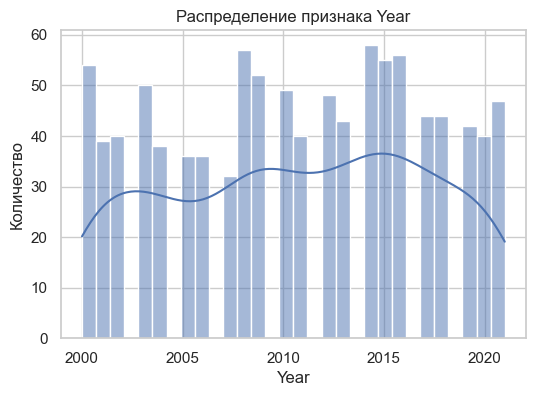

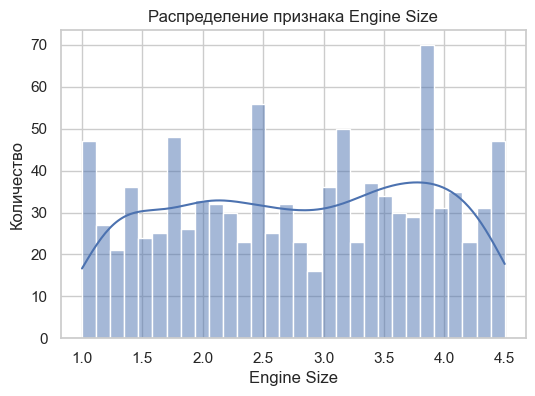

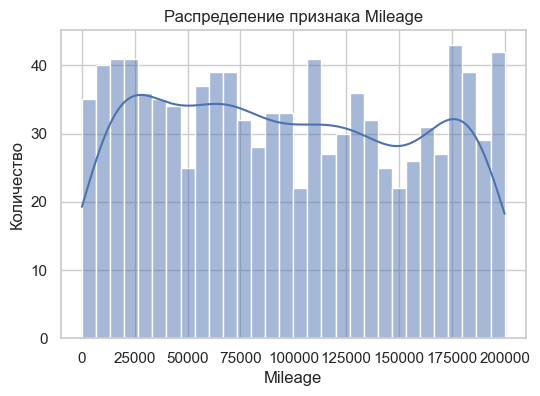

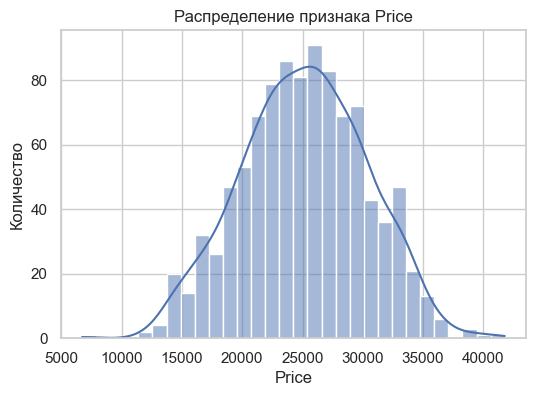

In [25]:
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Распределение признака {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.show()

Категориальные признаки

In [26]:
categorical_features = ['Make', 'Model', 'Fuel Type', 'Transmission']

Столбчатые диаграммы для категориальных признаков

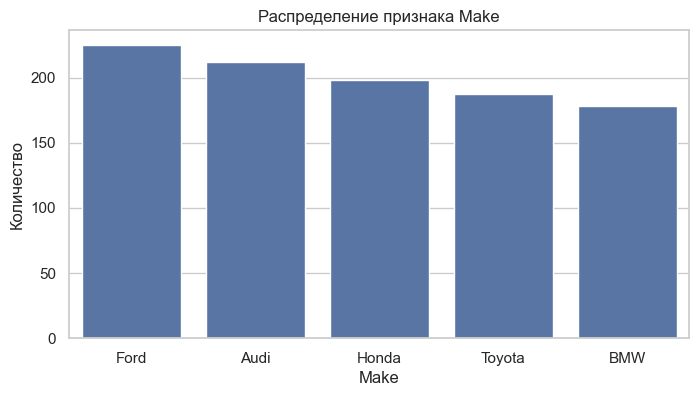

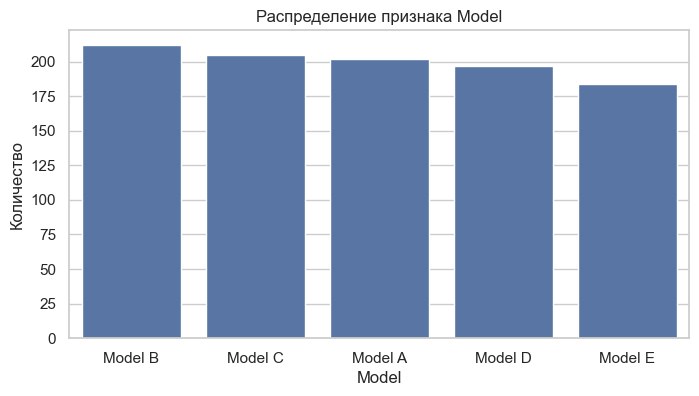

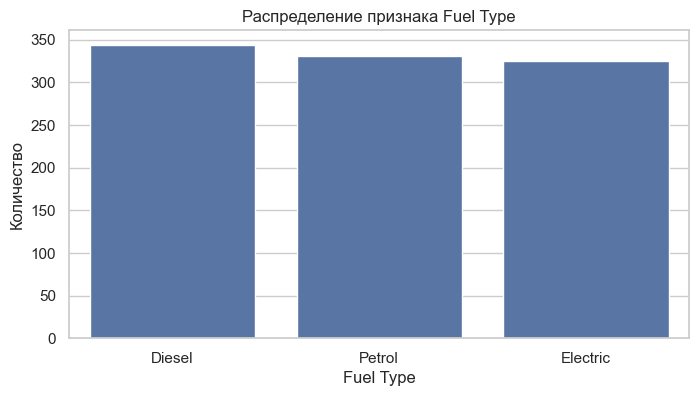

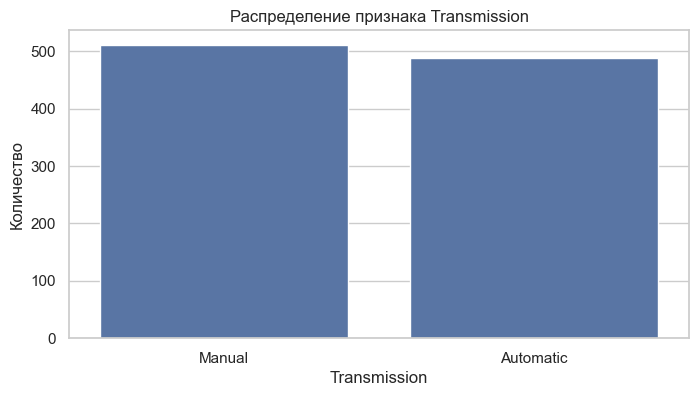

In [27]:
for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Распределение признака {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.xticks()
    plt.show()

3. Проведём предобработку данных:

Удаляем строки с пропущенными значениями

In [28]:
df = df.dropna()

Выделяем числовые и категориальные переменные

In [29]:
numeric_features = ['Year', 'Engine Size', 'Mileage']
categorical_features = ['Make', 'Model', 'Fuel Type', 'Transmission']

В x записываем признаки, исключая целевую переменную
В y записываем целевую переменную

In [30]:
X = df.drop("Price", axis=1)
y = df["Price"]

Создаем трансформеры для предобработки признаков. 
StandardScaler - для стандартизации числовых признаков(среднее значение будет равно 0, стандартное отклонение - 1) 
OneHotEncoder - для кодирования категориальных признаков. drop="first" - удаляет первую категорию, чтобы сразу избежать мультиколлинеарности

In [31]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)

Предобрабатываем признаки, используя созданные трансформеры

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

In [33]:
print(f"Исходные признаки: {X.shape}")
print(f"Предобработанные признаки: {X_processed.shape}")

Исходные признаки: (1000, 7)
Предобработанные признаки: (1000, 14)


4. Матрица корреляции
Создаём DataFrame из предобработанных признаков

In [34]:
X_df = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())

Добавляем целевую переменную

In [35]:
df_corr = X_df.copy()
df_corr["Price"] = y

Вычисляем коэффиценты корреляции Пирсона между всеми парами признаков. Получаем матрицу корреляций.

In [36]:
corr_matrix = df_corr.corr()

Рисуем матрицу

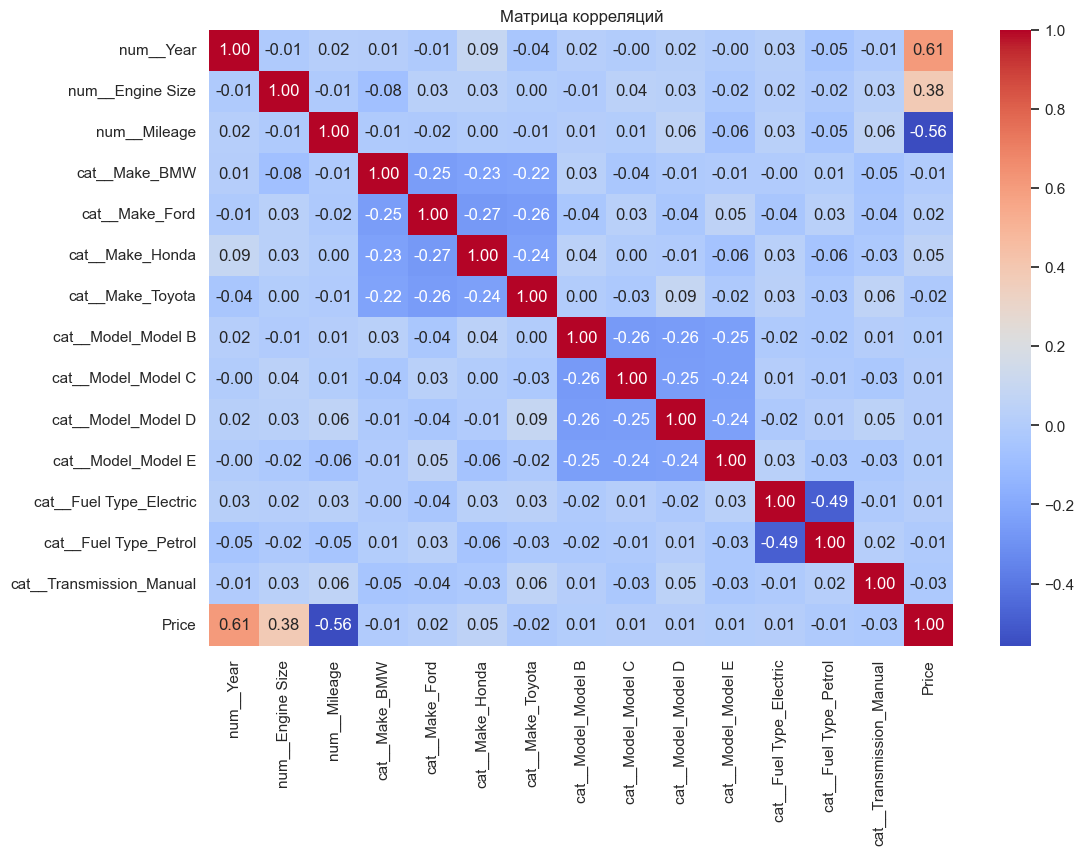

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляций")
plt.show()

Рассчитываем VIF

In [38]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(f"VIF:\n{vif_data}")

VIF:
                     feature       VIF
0                  num__Year  1.012704
1           num__Engine Size  1.011298
2               num__Mileage  1.013793
3              cat__Make_BMW  1.479782
4             cat__Make_Ford  1.616119
5            cat__Make_Honda  1.537416
6           cat__Make_Toyota  1.586037
7         cat__Model_Model B  1.622102
8         cat__Model_Model C  1.565908
9         cat__Model_Model D  1.616662
10        cat__Model_Model E  1.507244
11   cat__Fuel Type_Electric  1.704582
12     cat__Fuel Type_Petrol  1.684870
13  cat__Transmission_Manual  1.860050


5. Регрессионные модели
    Разделение на тренировочную и тестовую выборки

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

Создаем объект линейной регрессии и обучаем её тренировочными данными

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Предсказываем значения целевой переменной для тестовых данных, используя обученную модель

In [41]:
y_pred_lin = lin_reg.predict(X_test)

Метод для оценки качества модели

In [42]:
def evaluate_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAPE: {mape:.2f}")

Оценим качество линейной регрессии

In [43]:
evaluate_model(y_test, y_pred_lin, "Линейная регрессия")


Линейная регрессия:
RMSE: 2237.29
R²: 0.82
MAPE: 0.08


Аналогично с гребневой регрессией

In [44]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

evaluate_model(y_test, y_pred_ridge, "Гребневая регрессия")


Гребневая регрессия:
RMSE: 2236.73
R²: 0.82
MAPE: 0.08


Используем кросс-валидацию моделей.
cv=5 - делим данные на 5 частей
scoring='r2' - оцениваем качество моделей по коэффиценту детерминации

In [45]:
cv_scores_lin = cross_val_score(lin_reg, X_df, y, cv=5, scoring='r2')
cv_scores_ridge = cross_val_score(ridge_reg, X_df, y, cv=5, scoring='r2')

print("\nКросс-валидация (R²):")
print(f"Линейная регрессия: {cv_scores_lin.mean():.2f}")
print(f"Гребневая регрессия: {cv_scores_ridge.mean():.2f}")


Кросс-валидация (R²):
Линейная регрессия: 0.83
Гребневая регрессия: 0.83


6. PCA
   Разделяем данные на тренировочные и тестовые 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

Применяем PCA — оставим столько компонент, чтобы сохранялось 95% дисперсии. PCA применяется только после разбиения данных, чтобы модель заранее не видела тестовые данные и это не повлияло на направление главных компонент

In [47]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Исходное количество признаков: {X_train.shape[1]}")
print(f"После PCA: {X_train_pca.shape[1]} компонентов")

Исходное количество признаков: 14
После PCA: 11 компонентов


7. Создаем линейную регрессию после PCA, обучаем её тренировочными данными
и предсказываем значения для тестовых данных 

In [48]:
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train)
y_pred_lin_pca = lin_reg_pca.predict(X_test_pca)

Аналогично делаем для гребневой регрессии

In [49]:
ridge_reg_pca = Ridge(alpha=1.0)
ridge_reg_pca.fit(X_train_pca, y_train)
y_pred_ridge_pca = ridge_reg_pca.predict(X_test_pca)

Проводим оценку качества

In [50]:
evaluate_model(y_test, y_pred_lin, "Линейная регрессия")
evaluate_model(y_test, y_pred_lin_pca, "Линейная регрессия (PCA)")
evaluate_model(y_test, y_pred_ridge, "Гребневая регрессия")
evaluate_model(y_test, y_pred_ridge_pca, "Гребневая регрессия (PCA)")


Линейная регрессия:
RMSE: 2237.29
R²: 0.82
MAPE: 0.08

Линейная регрессия (PCA):
RMSE: 2234.47
R²: 0.82
MAPE: 0.08

Гребневая регрессия:
RMSE: 2236.73
R²: 0.82
MAPE: 0.08

Гребневая регрессия (PCA):
RMSE: 2233.97
R²: 0.82
MAPE: 0.08
